In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 9.0)
import time
from prettytable import PrettyTable

## Introduction

We have define the proximal gradient as $\frac{1}{\eta_k}[x_k - \text{prox}_{\eta_k g}(x_k - \eta_k ∇f(x_k))]$ (according to the lecture notes) and have used this as a stopping criterion.

In the following sections, we implement the proximal gradient algorithm (as described in the lecture notes) and the APG variants described in the Paper (Liu et al, 2017). These APG variants are `APG`, monotone APG (`mAPG`), APG for nonconvex programming (`APGnc`), the variant proposed in Section 3.2, `APGncp`, and finally, my modification to APGnp, which is `mAPGnp`.

I extract the function values in each case and make a plot of function values against iteration number. The duration of each algorithm is also recorded. I used a Windows 7 with Intel Core i5-1035G4 CPU @ 1.10GHz with installed RAM of 8.00GB.

## Function Implementations

In [164]:
#Proximal gradient algorithm

def proxgrad(F, gradf, proxg, L, ell, 
             x0, tol, maxit):
  x =x0
  alpha = 1/L
  gx = np.inf
  k, numit=0,0
  
  ##Added for convenience
  F_vals = []
  times = []
  ###Added


  while np.linalg.norm(gx) > tol and k <maxit:

    ##Added
    start_time = time.time()
    F_vals.append((F(x),k))
    #Added

    
    yx = x - alpha*gradf(x)
    px = proxg(yx)
    #print(px)
    gx = (1/alpha)*(x - px) #proximal gradient
    x = x - alpha*gx
    numit+=1
    k+=1
    #print(f"Fz={F(x)}; k={k}; norm={np.linalg.norm(gx)}")
    ##Added
    end_time = time.time()
    times.append(end_time-start_time)
  #return x, k, F_vals, times
    #Added
  if np.linalg.norm(gx) > tol:
    return x, maxit+1, F_vals, times 
  return x, k, F_vals, times

In [165]:
def apg(F, gradf, proxg, L, x0, tol, maxit):
  x=x0
  tempx=x
  y=x0

  eta = 1/L
  t0=0
  t1=1
  gx = np.inf
  k=0

  ##Added for convenience
  F_vals = []
  times = []
  ###Added


  while np.linalg.norm(gx) > tol and k <maxit:

    ##Added
    start_time = time.time()
    F_vals.append((F(x),k))
    #Added

    
    y = x + (t0-1)/t1 * (x - tempx)
    tempx=x
    
    yx = y - eta*gradf(y)
    px = proxg(yx)
    gx = (1/eta)*(y-px) #proximal gradient
    x = y - eta*gx
    t0=t1
    t1=(np.sqrt(4*t0**2 + 1) + 1) / 2
    k+=1

    ##Added
    end_time = time.time()
    times.append(end_time-start_time)
    ##Added
  if np.linalg.norm(gx) > tol:
    return x, maxit+1, F_vals, times
  return x, k, F_vals, times

In [166]:
#Montone APG

def mapg(F, gradf, proxg, L, x0, tol, maxit):
  x=x0 #x_1 = x_0
  tempx=x
  y=x0 #y_1 = x_0
  z=x0

  eta = 1/L
  t0=0
  t1=1
  gx = np.inf
  k=0

  ##Added for convenience
  F_vals = []
  times = []
  ###Added



  while np.linalg.norm(gx) > tol and k <maxit:

    ##Added
    start_time = time.time()
    F_vals.append((F(x),k))
    #Added

    
    y = x + t0/t1 * (z - x) + (t0 -1)/t1 *(x - tempx)
    tempx=x
    
    gy=(1/eta)*(y-proxg(y - eta*gradf(y)))
    z = y - eta*(gy)
    gx=(1/eta)*(x-proxg(x - eta*gradf(x)))
    v = x - eta*(gx)

    t0=t1
    t1=(np.sqrt(4*t0**2 + 1) + 1) / 2
    #print(f"x={x}; z={z}; Fz={F(z)}; Fv={F(v)}")
    if F(z) <= F(v):
      x = z
    elif F(v) <= F(z):
      x=v
      
    k+=1
    ##Added
    end_time = time.time()
    times.append(end_time-start_time)
    ##Added
  if np.linalg.norm(gx) > tol:
    return x, maxit+1, F_vals, times
  return x, k, F_vals, times

In [167]:
#APG non-convex

def ncapg(F, gradf, proxg, L, x0, tol, maxit):
  x=x0 #x_1 = x_0
  tempx=x
  y=x0 #y_1 = x_0
  z=x0

  eta = 1/L
  #t0=0
  #t1=1
  gy = np.inf
  k=0
  
  
  ##Added for convenience
  F_vals = []
  times = []
  ###Added


  
  while np.linalg.norm(gy) > tol and k <maxit:

    ##Added
    start_time = time.time()
    F_vals.append((F(x),k))
    #Added


    gy=(1/eta)*(y-proxg(y - eta*gradf(y)))
    x = y - eta*(gy)

    betak = k / (k+3)
    v = x + betak *(x - tempx)
    tempx=x

    if F(x) <= F(v):
      y = x
    elif F(v) <= F(x):
      y=v
    k+=1
    ##Added
    end_time = time.time()
    times.append(end_time-start_time)
    ##Added
  if np.linalg.norm(gy) > tol:
    return x, maxit+1, F_vals, times
  return x, k, F_vals, times

In [168]:
#APG non-convex without mean

def ncpapg(F, gradf, proxg, L, x0, tol, maxit):
  x=x0 #x_1 = x_0
  tempx=x
  y=x0 #y_1 = x_0
  #z=x0

  eta = 1/L
  #t0=0
  #t1=1
  gy = np.inf
  k=0
  betak, t = 0.5, 0.5
  avgx= []

  ##Added for convenience
  F_vals = []
  times = []
  ###Added


  while np.linalg.norm(gy) > tol and k <maxit:

    ##Added
    start_time = time.time()
    F_vals.append((F(x),k))
    #Added

    
    gy=(1/eta)*(y-proxg(y - eta*gradf(y)))
    x = y - eta*(gy)
    
    
    #betak = k / (k+3)
    v = x + betak *(x - tempx)
    #x = np.mean(np.c_[x, tempx], axis=1) #newly added
    avgx.append(x)
    tempx=x
    
    
    if F(x) <= F(v):
      y = x
      betak = t*betak
    elif F(v) <= F(x):
      y=v
      betak = min(betak/t, 1)

    k+=1
    ##Added
    end_time = time.time()
    times.append(end_time-start_time)
    ##Added
  if np.linalg.norm(gy) > tol:
    return x, maxit+1, F_vals, times
  return x, k, F_vals, times

In [169]:
#APG non-convex

def mncpapg(F, gradf, proxg, L, x0, tol, maxit):
  x=x0 #x_1 = x_0
  tempx=x
  y=x0 #y_1 = x_0
  #z=x0

  eta = 1/L
  #t0=0
  #t1=1
  gy = np.inf
  k=0
  betak, t = 0.5, 0.5
  #avgx= []

  ##Added for convenience
  F_vals = []
  times = []
  ###Added



  while np.linalg.norm(gy) > tol and k <maxit:

    ##Added
    start_time = time.time()
    F_vals.append((F(x),k))
    #Added


    gy=(1/eta)*(y-proxg(y - eta*gradf(y)))
    x = y - eta*(gy)
    
    
    #betak = k / (k+3)
    v = x + betak *(x - tempx)
    x = np.mean(np.c_[x, tempx], axis=1) #newly added
    #avgx.append(x)
    tempx=x
    
    
    if F(x) <= F(v):
      y = x
      betak = t*betak
    elif F(v) <= F(x):
      y=v
      betak = min(betak/t, 1)

    k+=1

    ##Added
    end_time = time.time()
    times.append(end_time-start_time)
    ##Added
  if np.linalg.norm(gy) > tol:
    return x, maxit+1, F_vals, times
  # return x, k
  return x, k, F_vals, times

## Analysis

### Data 1

Data 1 is the dataset from the paper. We project it onto the positive simplex. The optimization problem is defined as below

$$
\min_{\boldsymbol x} -\frac{1}{2} \boldsymbol x^T \Big ( \sum_{i=1}^n \boldsymbol z_i \boldsymbol z^T_i \Big ) \boldsymbol x + \gamma \|\boldsymbol x\|^2  \quad \text{s.t.} \: \boldsymbol x \geq 0, \boldsymbol 1^T \boldsymbol x = 1
$$

This is a nonconvex optimization problem due to the negative sign

The data is created using $n=1000$, $\gamma = 10^{-3}$. $\boldsymbol z_i$ is randomly generated from a normal distribution and is normalized to have unit norm, like in the referenced paper

In [170]:
def F(A,gamma):
  def get_G(x, A, gamma):
    f = -0.5*x.T@A@x + gamma* np.linalg.norm(x,ord=2)**2
    #g = np.int64(x > 0) * x.T@x
    return f
  return lambda x: get_G(x,A,gamma)

def get_gradf_function(A,gamma):
  #Grad of f
  def get_grad(x,A,gamma):
    grad = -A@x + 2*gamma*np.identity(A.shape[1])@x
    return grad
  return lambda x : get_grad(x,A,gamma)

def prox_xg():
  def proxggx(x, z=1.):
    ##Projection of v onto positive simplex

    u = np.sort(x)[::-1] 
    p = (np.cumsum(u) - z) / np.arange(1., len(x) + 1.)
    return np.maximum(x - p[np.nonzero(u > p)[0][-1]], 0.)
  return lambda x: proxggx(x)

Generate data and specify parameters

In [171]:
X = np.random.randn(500,50)
X = X / ((X**2).sum(axis=1)**(1/2)).reshape((-1,1))
A = X.T@X

In [172]:
x0=np.zeros(A.shape[0]) #initial value
#x0=np.random.randn(A.shape[0])
w,_ = np.linalg.eigh(A.T@A) #get eigenvalues
L, ell = np.max(w), np.min(w) #Obtain approximate values for L and \ell
tol =1e-4
maxit=2000000
gamma = 1e-3
grad = get_gradf_function(A, gamma)
t, step_=1, 1/L
proxgg = prox_xg()
Fx = F(A, gamma)

Carry out computations

In [173]:
resultsprox, iterationsprox, Fvalsprox, proxtimes = proxgrad(Fx, grad, proxgg, L,ell,x0,tol,maxit)
resultsapg, iterationsapg, Fvalsapg, apgtimes = apg(Fx,grad, proxgg, L,x0,tol,maxit)
resultsmpg, iterationsmpg, Fvalsmpg, mpgtimes = mapg(Fx, grad, proxgg, L,x0,tol,maxit)
resultsnc, iterationsnc, Fvalsnc, nctimes = ncapg(Fx, grad, proxgg, L,x0,tol,maxit)
resultsncp, iterationsncp, Fvalsncp, ncptimes, = ncpapg(Fx, grad, proxgg, L,x0,tol,maxit)
resultsmnc, iterationsmnc, Fvalsmnc, mnctimes = mncpapg(Fx, grad, proxgg, L,x0,tol,maxit)

Plots

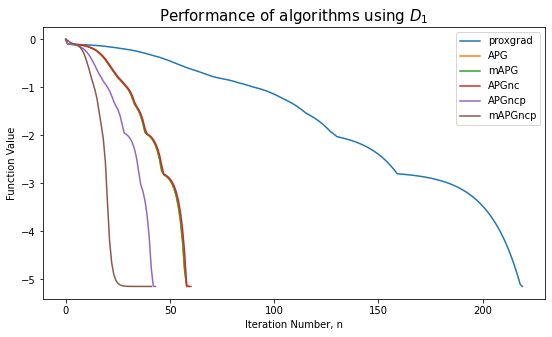

In [174]:
aa = list(zip(*Fvalsprox)) #proximal gradient
bb = list(zip(*Fvalsapg)) #APG
cc = list(zip(*Fvalsmpg)) #montone
dd = list(zip(*Fvalsnc)) #non-convex
ee = list(zip(*Fvalsncp)) #non-convex +
ff = list(zip(*Fvalsmnc)) #Mean non-convex +

plt.figure(figsize=(9,5))
plt.plot(aa[1], np.array(aa[0]), label='proxgrad')
plt.plot(bb[1], np.array(bb[0]), label='APG')
plt.plot(cc[1], np.array(cc[0]), label='mAPG')
plt.plot(dd[1], np.array(dd[0]), label='APGnc')
plt.plot(ee[1], np.array(ee[0]), label='APGncp')
plt.plot(ff[1], np.array(ff[0]), label='mAPGncp')
# plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='upper right', prop={'size': 10})
plt.title(r"Performance of algorithms using $D_1$", fontsize=15)
plt.ylabel("Function Value", fontsize=10)
plt.xlabel("Iteration Number, n", fontsize=10)
plt.show()

We observe that `APG`, `mAPG` and `APGnc` have near same performance. Proximial gradient method, implemented as a benchmark, performed worst. `APGncp`, the algorithm proposed in the paper performed much better than all of these algorithms. However, my extension of `APGncp` appears to perform best.

In [ ]:
algos = [
         'proxgrad',
         'APG',
         'mAPG',
         'APGnc',
         'APGncp',
         'mAPGncp'
]
alltimes = np.round(np.array([np.array(proxtimes).sum(),
 np.array(apgtimes).sum(),
 np.array(mpgtimes).sum(),
 np.array(nctimes).sum(),
 np.array(ncptimes).sum(),
 np.array(mnctimes).sum()
 ]),4)

In [ ]:
t = PrettyTable(['Algorithm', 'Total Time'])
for i,j in list(zip(*[algos, alltimes])):
    t.add_row([i,j])
print('<===Using Data 1===>')
print(t)

print('\n')

<===Using Data 1===>
+-----------+------------+
| Algorithm | Total Time |
+-----------+------------+
|  proxgrad |   0.0345   |
|    APG    |   0.0053   |
|    mAPG   |   0.0122   |
|   APGnc   |   0.0091   |
|   APGncp  |   0.0072   |
|  mAPGncp  |   0.0137   |
+-----------+------------+




### Data 2

To further compare the implemented algorithms, we use additional data and functions. Data 2 is the `cdcdata.txt` from PS2. We implement least squares with $\ell_1$ regularization. This is a convex optimization problem.

$$
\min_{\boldsymbol x \in \mathbb{R}^n} \|A \boldsymbol x - b\|^2 + \lambda\|\boldsymbol x\|_1
$$

In [175]:
def F(A,b,gamma):
  def get_F(x,A,b,gamma):
    Ax_b = A.dot(x) - b
    f = 0.5*(Ax_b.T.dot(Ax_b))
    g = gamma*np.linalg.norm(x, ord=1)
    return f + g
    #return f
  return lambda x: get_F(x,A,b,gamma)

def get_gradf_function(A,b):
  #Grad of f
  def get_least_squares(x,A,b):
    grad = A.T@(A@x - b)
    return grad
  return lambda x : get_least_squares(x,A,b)

def prox_xg(step_size, lamda):
  #prox for L1 norm
  def proxggx(x, step_size, lamda):
    return np.fmax(x - step_size*lamda, 0) - np.fmax(-x-step_size*lamda,0)
  return lambda x: proxggx(x, step_size, lamda)

In [176]:
A = np.loadtxt("cdcdata.txt")
A[:,0] = A[:,0] - 1900 #preprocess data
X = A[:, :-1] #Obtain X component of data
X = np.c_[X, np.ones(len(A))]
y = A[:, -1] #Obtain y component of data

x0=np.array([0,0]) #initial value
w,_ = np.linalg.eig(X.T@X) #get eigenvalues
L, ell = np.max(w), np.min(w) #Obtain L and \ell
tol =1e-4
maxit=2000000
grad = get_gradf_function(X,y)
t, step_=0.1, 1/L
proxgg = prox_xg(step_, t)
Fx = F(X,y,t)

Carry out computations

In [177]:
resultsprox, iterationsprox, Fvalsprox, proxtimes = proxgrad(Fx, grad, proxgg, L,ell,x0,tol,maxit)
resultsapg, iterationsapg, Fvalsapg, apgtimes = apg(Fx,grad, proxgg, L,x0,tol,maxit)
resultsmpg, iterationsmpg, Fvalsmpg, mpgtimes = mapg(Fx, grad, proxgg, L,x0,tol,maxit)
resultsnc, iterationsnc, Fvalsnc, nctimes = ncapg(Fx, grad, proxgg, L,x0,tol,maxit)
resultsncp, iterationsncp, Fvalsncp, ncptimes, = ncpapg(Fx, grad, proxgg, L,x0,tol,maxit)
resultsmnc, iterationsmnc, Fvalsmnc, mnctimes = mncpapg(Fx, grad, proxgg, L,x0,tol,maxit)

In [178]:
#See results
resultsncp #matches with output from PS2

array([ 0.28180976, 50.57384287])

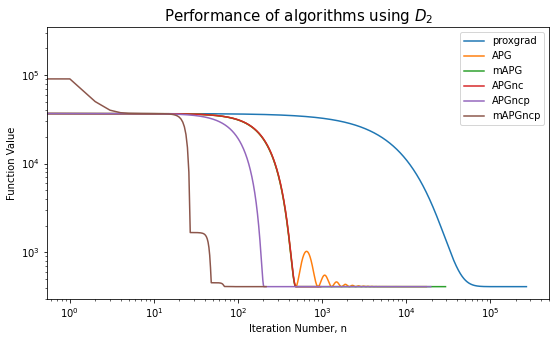

In [179]:
aa = list(zip(*Fvalsprox)) #proximal gradient
bb = list(zip(*Fvalsapg)) #APG
cc = list(zip(*Fvalsmpg)) #montone APG
dd = list(zip(*Fvalsnc)) #non-convex
ee = list(zip(*Fvalsncp)) #non-convex +
ff = list(zip(*Fvalsmnc)) #Mean non-convex +

plt.figure(figsize=(9,5))
plt.plot(aa[1], np.array(aa[0]), label='proxgrad')
plt.plot(bb[1], np.array(bb[0]), label='APG')
plt.plot(cc[1], np.array(cc[0]), label='mAPG')
plt.plot(dd[1], np.array(dd[0]), label='APGnc')
plt.plot(ee[1], np.array(ee[0]), label='APGncp')
plt.plot(ff[1], np.array(ff[0]), label='mAPGncp')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right', prop={'size': 10})
plt.title(r"Performance of algorithms using $D_2$", fontsize=15)
plt.ylabel("Function Value", fontsize=10)
plt.xlabel("Iteration Number, n", fontsize=10)
plt.show()

We observe that `mAPG`, `APGnc` and `APGncp` have nearly the same performance for this convex optimization problem. They attain nearly the same function values at the same iteration numbers. The algorithm proposed in the paper `APGncp` performs much better than the earlier three. My extension of `APGncp` appears to perform best, attaining lower function values at earlier iterations. The proximal gradient method, implemented as a benchmark, performed worst.

In [ ]:
alltimes = np.round(np.array([np.array(proxtimes).sum(),
 np.array(apgtimes).sum(),
 np.array(mpgtimes).sum(),
 np.array(nctimes).sum(),
 np.array(ncptimes).sum(),
 np.array(mnctimes).sum()
 ]),4)

t = PrettyTable(['Algorithm', 'Total Time'])
for i,j in list(zip(*[algos, alltimes])):
    t.add_row([i,j])
print('<===Using Data 2===>')
print(t)

print('\n')

<===Using Data 2===>
+-----------+------------+
| Algorithm | Total Time |
+-----------+------------+
|  proxgrad |   8.0565   |
|    APG    |   0.6288   |
|    mAPG   |   2.7419   |
|   APGnc   |   0.064    |
|   APGncp  |   0.9937   |
|  mAPGncp  |   0.0258   |
+-----------+------------+




### Data 3

Finally, we use Data 3 to test the performance of all the algorithms. Data 3 is a sparse logistic regression problem, sparse LR. 

\begin{equation}
    \min_{\boldsymbol x} \sum_{i:y_i=1} -\boldsymbol z_i^T \boldsymbol x + \sum_{i=1}^n \log(1 + \exp(\boldsymbol z_i^T\boldsymbol x)) + r(\boldsymbol x)
\end{equation}

where $r(\boldsymbol x)$ is chosen as the capped $\ell_1$ penalty defined as 

\begin{equation}
    r(\boldsymbol x) = \lambda \sum_{i=1}^d \min (|x_i|, \theta), \quad \theta > 0, \lambda >0
\end{equation}

As detailed in the paper (Zhang, 2008), this function serves useful applications in several areas. In this case, we use a subset of the MNIST data set which has only 5000 training samples and 1000 testing samples of 1's and 3's. We carry out a classification task.

In [108]:
def prox_xg(theta, gamma):
  def proxggx(d, theta, gamma):
    n = d.shape[0]
    v = np.zeros(n)
    for i in range(n):
      u = np.abs(d[i])
      v1 = np.max([u, theta])
      v2 = np.min([theta, np.max([0, u-gamma])])
      if (0.5*(v1 + v2 - 2*u)*(v1 - v2) + gamma*(theta - v2) < 0):
        v[i] = v1
      else:
        v[i] = v2
      if d[i]>=0:
        v[i] = v[i]
      else:
        v[i] = -v[i]
    return v
  return lambda x: proxggx(x, theta, gamma)

def sigmoid(x):
  return 1/(1+np.exp(-x))
  
def gradfXy(X, y):
  def get_grad(u, X, y):
    #m = len(y)
    #grad = np.zeros([m,1])
    grad = X.T @ (sigmoid(X @ u) - y)
    #grad = grad + (lambda_ * u)
    return grad
  return lambda x : get_grad(x,X,y)

def F(X, y, gamma, theta):
  def getF(u, X, y, gamma, theta):
    #n = X.shape[1]
    f = (-1*(X*(y.reshape((-1,1))))@u).sum() + np.sum(np.log(1 + np.exp(X@u)))
    g = gamma*np.sum(np.minimum(np.abs(u), theta))
    f = (f + g)
    #f = - X.T@y@u  + np.log( 1 + sigmoid(X @ u) ) + gamma*np.sum(np.minimum(np.abs(u), theta))
    return f
  return lambda x: getF(x, X, y, gamma, theta)

In [ ]:
#Obtain data
! curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
! curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
! curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
! curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0   111M      0 --:--:-- --:--:-- --:--:--  111M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0   829k      0 --:--:-- --:--:-- --:--:--  881k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  22.4M      0 --:--:-- --:--:-- --:--:-- 22.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0   192k      0 --:--:-- --:--:-- --:--:--  192k


In [ ]:
! gunzip t*-ubyte.gz

In [ ]:
from mlxtend.data import loadlocal_mnist
import platform
#Obtain training and test sets
trainX, trainY = loadlocal_mnist(
 images_path='train-images-idx3-ubyte',
 labels_path='train-labels-idx1-ubyte')
testX, testY = loadlocal_mnist(
 images_path='t10k-images-idx3-ubyte',
 labels_path='t10k-labels-idx1-ubyte')

In [ ]:
#Obtain just 1's and 3's
y_train = trainY[(trainY==1) | (trainY==3)]
X_train = trainX[(trainY==1) | (trainY==3), :]
y_test = testY[(testY==1) | (testY==3)]
X_test =testX[(testY==1) | (testY==3), :]

In [ ]:
#Obtain random samples. Just 5000 training samples and 1000 test samples
STATE=2022
np.random.seed(STATE)
r, _ = X_train.shape
s, _ = X_test.shape
random_indices_tr = np.random.choice(r, size=5000, replace=False)
random_indices_ts = np.random.choice(s, size=1000, replace=False)

X_train_sample = X_train[random_indices_tr, :]
y_train_sample = y_train[random_indices_tr]
X_test_sample = X_test[random_indices_ts, :]
y_test_sample = y_test[random_indices_ts]

In [128]:
print(X_train_sample.shape, y_train_sample.shape)
print(X_test_sample.shape, y_test_sample.shape)

(5000, 784) (5000,)
(1000, 784) (1000,)


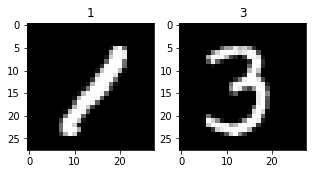

In [ ]:
#Examine sample instance
v = np.random.choice(np.arange(5000))
u = np.random.choice(np.arange(5000))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(5,5))
ax1.imshow(X_train_sample[v,:].reshape((28,28)), cmap='gray')
ax1.set_title(str(y_train_sample[v]))
ax2.imshow(X_train_sample[u,:].reshape((28,28)), cmap='gray')
ax2.set_title(str(y_train_sample[u]))
plt.show()

In [139]:
gamma = 1e-4
theta = 0.1*gamma #Specify lambda's
X_s = X_train_sample / np.max(np.linalg.norm(X_train_sample, axis=1)) #Scale training 
Xt_s = X_test_sample / np.max(np.linalg.norm(X_test_sample, axis=1)) #Scale test
tol = 0.1 #Specify lower tolerance
maxit = 10000 #Max iterations
y_train = (y_train_sample==1).astype(int)
y_test = (y_test_sample==1).astype(int)

In [140]:
x0 = np.zeros(X_s.shape[1])
w, _ = np.linalg.eigh(X_s.T @ X_s)
L, l = np.max(w) + gamma, gamma #Obtain estimates L and \ell
gradf = gradfXy(X_s, y_train)
t, step_=0.1, 1/L
proxgg = prox_xg(step_, t)
Fx = F(X_s,y_train,gamma,theta)

In [132]:
resultsprox, iterationsprox, Fvalsprox, proxtimes = proxgrad(Fx, gradf, proxgg, L,l,x0,tol,maxit)
print("maxit: ", iterationsprox)

maxit:  10001


In [133]:
resultsapg, iterationsapg, Fvalsapg, apgtimes = apg(Fx,gradf, proxgg, L,x0,tol,maxit)
print("maxit: ", iterationsapg)

maxit:  3830


In [134]:
resultsmpg, iterationsmpg, Fvalsmpg, mpgtimes = mapg(Fx, gradf, proxgg, L,x0,tol,maxit)
print("maxit: ", iterationsmpg)

maxit:  3831


In [141]:
resultsnc, iterationsnc, Fvalsnc, nctimes = ncapg(Fx, gradf, proxgg, L,x0,tol,maxit)
print("maxit: ", iterationsnc)

maxit:  3824


In [142]:
resultsncp, iterationsncp, Fvalsncp, ncptimes, = ncpapg(Fx, gradf, proxgg, L,x0,tol,maxit)
print("maxit: ", iterationsncp)

maxit:  5007


In [143]:
resultsmnc, iterationsmnc, Fvalsmnc, mnctimes = mncpapg(Fx, gradf, proxgg, L,x0,tol,maxit)
print("maxit: ", iterationsmnc)

maxit:  9879


In [144]:
results = [
           resultsprox,
           resultsapg,
           resultsmpg,
           resultsnc,
           resultsncp,
           resultsmnc
]

In [145]:
def score_logistic(testX, testY, u):
  #ux = np.r_[u, u0]
  pred = (sigmoid(np.dot(testX, u)) >= 0.5).astype(int)
  return np.mean(pred == testY.flatten()) * 100

In [155]:
for i,j in zip(algos, results):
  print("Accuracy on Test set for " + str(i) + ": " + str(round(100 - score_logistic(Xt_s, y_test, j),2))+ "%")


Accuracy on Test set for proxgrad: 0.7%
Accuracy on Test set for APG: 1.4%
Accuracy on Test set for mAPG: 1.4%
Accuracy on Test set for APGnc: 1.6%
Accuracy on Test set for APGncp: 1.6%
Accuracy on Test set for mAPGncp: 1.4%


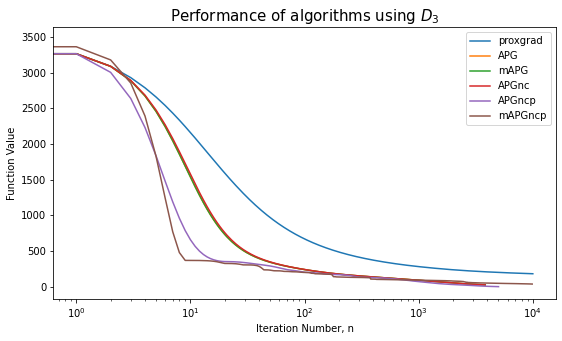

In [163]:
aa = list(zip(*Fvalsprox)) #proximal gradient
bb = list(zip(*Fvalsapg)) #APG
cc = list(zip(*Fvalsmpg)) #montone APG
dd = list(zip(*Fvalsnc)) #non-convex
ee = list(zip(*Fvalsncp)) #non-convex +
ff = list(zip(*Fvalsmnc)) #Mean non-convex +

plt.figure(figsize=(9,5))
plt.plot(aa[1], np.array(aa[0]), label='proxgrad')
plt.plot(bb[1], np.array(bb[0]), label='APG')
plt.plot(cc[1], np.array(cc[0]), label='mAPG')
plt.plot(dd[1], np.array(dd[0]), label='APGnc')
plt.plot(ee[1], np.array(ee[0]), label='APGncp')
plt.plot(ff[1], np.array(ff[0]), label='mAPGncp')
plt.xscale('log')
#plt.yscale('log')
plt.legend(loc='upper right', prop={'size': 10})
plt.title(r"Performance of algorithms using $D_3$", fontsize=15)
plt.ylabel("Function Value", fontsize=10)
plt.xlabel("Iteration Number, n", fontsize=10)
plt.show()

In [161]:
alltimes = np.round(np.array([np.array(proxtimes).sum(),
 np.array(apgtimes).sum(),
 np.array(mpgtimes).sum(),
 np.array(nctimes).sum(),
 np.array(ncptimes).sum(),
 np.array(mnctimes).sum()
 ]),4)

t = PrettyTable(['Algorithm', 'Total Time'])
for i,j in list(zip(*[algos, alltimes])):
    t.add_row([i,j])
print('<===Using Data 2===>')
print(t)

print('\n')

<===Using Data 2===>
+-----------+------------+
| Algorithm | Total Time |
+-----------+------------+
|  proxgrad |  589.4469  |
|    APG    |  224.2139  |
|    mAPG   |  533.7308  |
|   APGnc   |  567.8207  |
|   APGncp  |   745.79   |
|  mAPGncp  | 1437.8501  |
+-----------+------------+


